In [ ]:
# 1. Carga de datos y librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
from sklearn.decomposition import PCA

# Carga del dataset
df = pd.read_csv('HR_comma_sep.csv')

In [ ]:
# 2. Limpieza de datos
print("Dimensiones del dataset:", df.shape)
print("Columnas:", df.columns.tolist())
df.head()

# Verificar valores nulos
df.isnull().sum()

# Detección y tratamiento de outliers en variables numéricas
numeric_cols = ['satisfaction_level', 'last_evaluation', 'number_project',
                'average_montly_hours', 'time_spend_company']

# Usamos el rango intercuartílico para detectar valores atípicos extremos
def tratar_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Recorte de valores extremos
        df[col] = np.where(df[col] < lower_bound, lower_bound,
                           np.where(df[col] > upper_bound, upper_bound, df[col]))
    return df

df = tratar_outliers(df, numeric_cols)

Dimensiones del dataset: (14999, 10)
Columnas: ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'left', 'promotion_last_5years', 'Department', 'salary']



Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  float64
 3   average_montly_hours   14999 non-null  float64
 4   time_spend_company     14999 non-null  float64
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(5), int64(3), object(2)
memory usage: 1.1+ MB

Valores faltantes por columna:
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident   

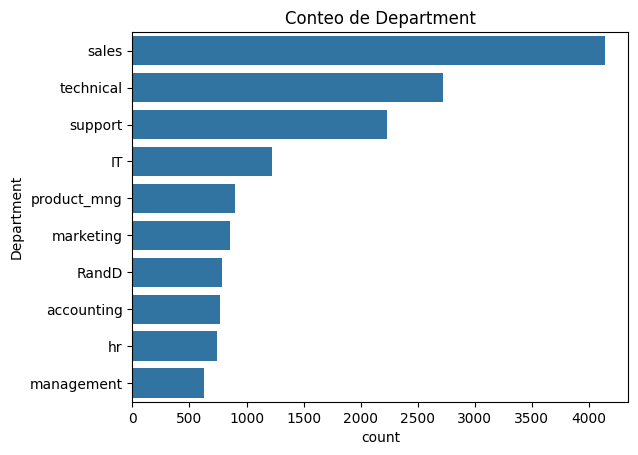

---- salary ----
salary
low       7316
medium    6446
high      1237
Name: count, dtype: int64


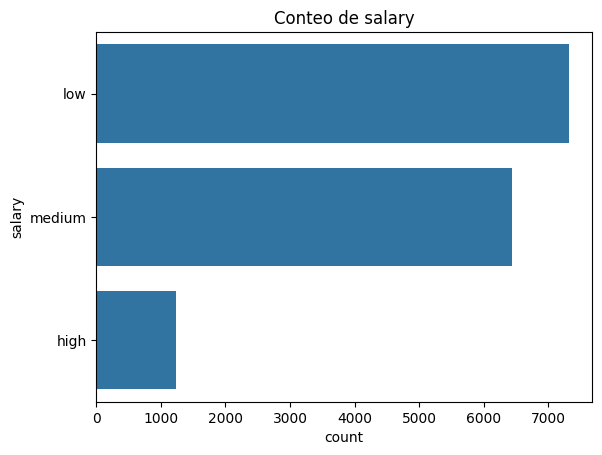

In [170]:
# 3. Exploración inicial
print("\nInformación general:")
df.info()
df.describe()

print("\nValores faltantes por columna:")
print(df.isnull().sum())

cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print('\nColumnas categóricas:', cat_cols)


for col in cat_cols:
  print('----', col, '----')
  print(df[col].value_counts())
  sns.countplot(y=col, data=df, order=df[col].value_counts().index)
  plt.title(f'Conteo de {col}')
  plt.show()

In [171]:
# 4. Codificación de variables categóricas
df_encoded = pd.get_dummies(df, columns=['Department', 'salary'], drop_first=True)

In [172]:
# 5. Separación de variables predictoras y objetivo
X = df_encoded.drop('left', axis=1)
y = df_encoded['left']

In [173]:
# 6. Estandarización de variables numéricas
scaler = StandardScaler()
numeric_cols = ['satisfaction_level', 'last_evaluation', 'number_project',
                'average_montly_hours', 'time_spend_company']
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

In [174]:
# 7. División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

print("Tamaño entrenamiento:", X_train.shape, "Tamaño prueba:", X_test.shape)
print("Proporción de abandonos en y_train:", y_train.mean(), "Proporción en y_test:", y_test.mean())

Tamaño entrenamiento: (11999, 18) Tamaño prueba: (3000, 18)
Proporción de abandonos en y_train: 0.2381031752646054 Proporción en y_test: 0.238


In [175]:
# 8. Entrenamiento de modelos
modelos = {
    'Regresión Logística': LogisticRegression(max_iter=1000, random_state=42),
    'Árbol de Decisión': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)



Modelo: Regresión Logística
F1 Score: 0.454
ROC AUC: 0.856


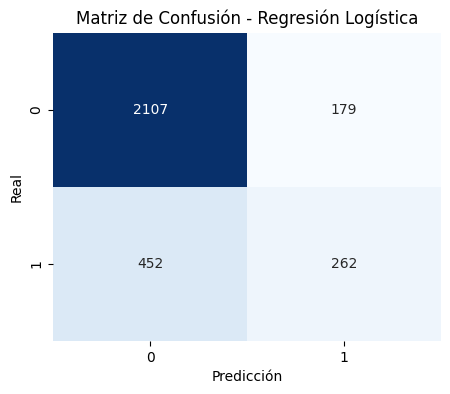


Modelo: Árbol de Decisión
F1 Score: 0.951
ROC AUC: 0.973


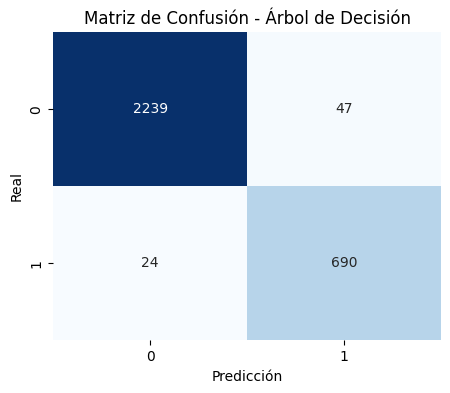


Modelo: Random Forest
F1 Score: 0.979
ROC AUC: 0.991


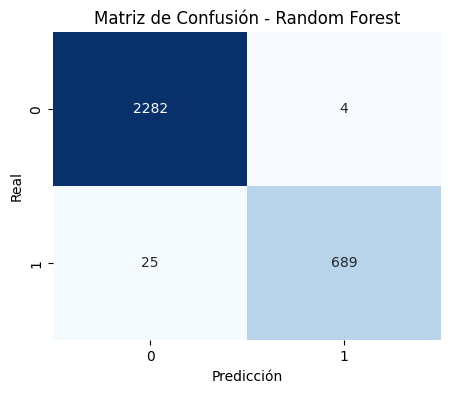

In [176]:
# 9. Evaluación de modelos
for nombre, modelo in modelos.items():
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1]
    print(f"\nModelo: {nombre}")
    print("F1 Score:", round(f1_score(y_test, y_pred), 3))
    print("ROC AUC:", round(roc_auc_score(y_test, y_prob), 3))
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - {nombre}')
    plt.show()

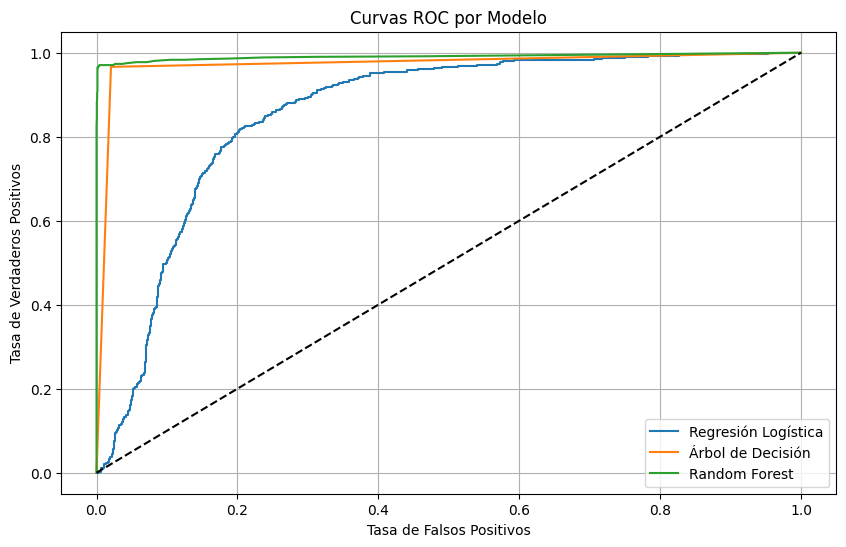

In [177]:
# 10. Curvas ROC
plt.figure(figsize=(10, 6))
for nombre, modelo in modelos.items():
    y_prob = modelo.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{nombre}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC por Modelo')
plt.legend()
plt.grid(True)
plt.show()

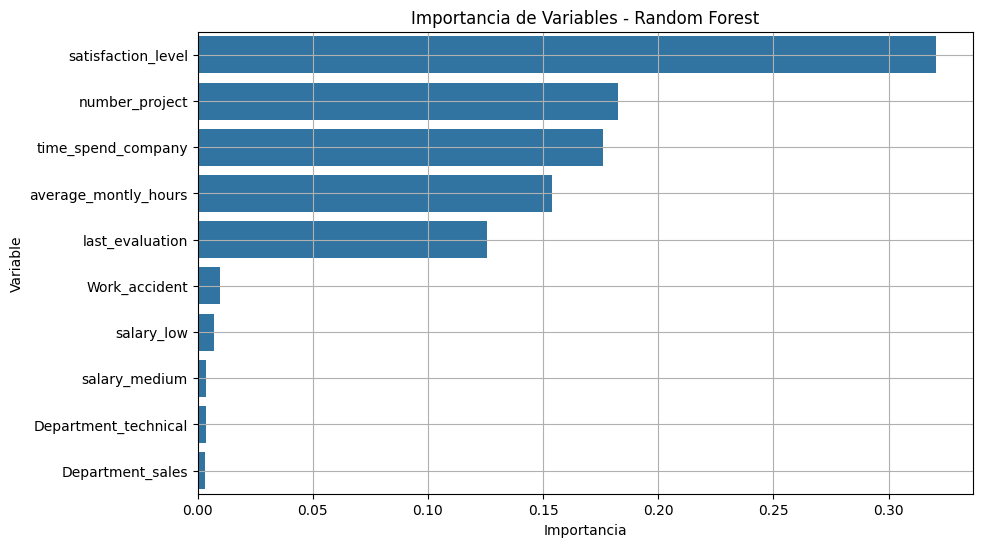

In [178]:
# 11. Importancia de variables (Random Forest)
importancias = modelos['Random Forest'].feature_importances_
indices = np.argsort(importancias)[::-1][:10]
plt.figure(figsize=(10, 6))
sns.barplot(x=importancias[indices], y=np.array(X.columns)[indices])
plt.title('Importancia de Variables - Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.grid(True)
plt.show()


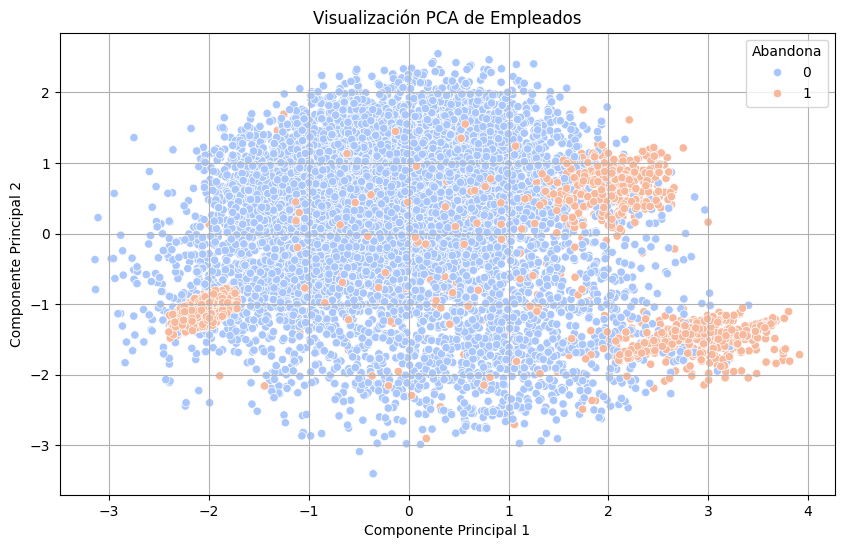

In [179]:
# 12. Visualización con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm')
plt.title('Visualización PCA de Empleados')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.legend(title='Abandona')
plt.show()

# Importancia de las variables en el modelo

El modelo Random Forest mostró que la satisfacción laboral es el factor más relevante para predecir el abandono de empleados. Le siguen en importancia:

- Antigüedad en la empresa: los empleados con 3 a 5 años tienen mayor probabilidad de irse.

- Número de proyectos y horas mensuales trabajadas: cargas laborales excesivas o muy bajas influyen en la decisión.

- Evaluación de desempeño: valores extremos pueden asociarse con riesgo de abandono.
Variables como promociones o accidentes laborales influyeron poco, posiblemente por su baja frecuencia en los datos.

# Propuestas de acciones preventivas
 - Monitorear periódicamente la satisfacción laboral y actuar frente a niveles bajos.
 - Equilibrar la carga laboral para evitar tanto el exceso como el desinterés por falta de tareas.
 - Implementar planes de carrera claros, especialmente para empleados con 3 a 5 años de antigüedad.
 - Reforzar políticas de reconocimiento y promociones internas.
 - Ajustar políticas salariales para mejorar la retención, sobre todo en empleados con alto desempeño.
 - Identificar departamentos con rotación elevada y aplicar estrategias focalizadas de mejora en clima y gestión.

Estas medidas permitirían disminuir la fuga de talento y fortalecer la estabilidad del equipo humano.